# Comparison of algortihms/ansatz in Li-H ground state search
## VQE
The Variational Quantum Eigensolver (VQE) is an algorithm for quantum computers that can be used to find the ground state energy of a quantum system. The algorithm is based on the variational principle, which states that the ground state energy of a system is the minimum energy that the system can have.
## AdaptVQE
ADAPT-VQE determines a quasi-optimal ansatz with the minimal number of operators for a desired level of accuracy. The key idea is to systematically grow the ansatz by adding fermionic operators one-at-a-time, such that the maximal amount of correlation energy is recovered at each step. This results in a wavefunction ansatz that is discovered by the algorithm, and which cannot be predicted a priori from a traditional excitation-based scheme like UCCSD
## VHA
The Variational Hamiltonian Ansatz (VHA) is inspired by the adiabatic quantum evolution under the influence of a time-dependent Hamiltonian, where the - ideally short - fixed Trotter time steps are replaced by variational parameters
## Variational Imaginary time evolution
The Variational Imaginary time evolution expresses the ground state as the long-time limit of the imaginary time Schrödinger equa-
tion

##

In [1]:
#CHECK VERSIONS OF QISKIT: 'qiskit-terra': '0.18.2','qiskit-aer': '0.9.0','qiskit-nature': '0.2.0'
import qiskit

print(qiskit.__qiskit_version__)

{'qiskit-terra': '0.18.2', 'qiskit-aer': '0.9.0', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': None, 'qiskit-aqua': '0.9.5', 'qiskit': '0.30.0', 'qiskit-nature': '0.2.0', 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}


/home/gsilvi/.local/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


Load the libraries

In [2]:
import os
os.environ["TMPDIR"] = "/tmp"  # set the folder for temporary files
import sys 
# sys.path.insert(0, '/home/gsilvi/.local/lib/python3.9/site-packages')

from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper
from qiskit_nature.algorithms import VQEUCCFactory,GroundStateEigensolver,AdaptVQE
from qiskit_nature.circuit.library import HartreeFock, UCCSD,UCC

from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SLSQP,L_BFGS_B,SPSA, COBYLA
from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian,DerivativeBase
from qiskit.circuit.library import TwoLocal
from qiskit.test.mock import FakeVigo
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator,QasmSimulator


from qiskit_mod.qiskit_nat import VHA
from qiskit_mod.qiskit_ter import LinCombFullmod,LinCombMod

import numpy as np 
import time as time
import datetime
import matplotlib.pyplot as plt

/home/gsilvi/miniforge3/envs/NEASQC4wMYQLM/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


Select to use:
- QLM backends or Qiskit backends
 - If QLM: remote or local
- noise or noiseless

In [3]:
use_qlm = True # instead of Qiskit

use_remote_qlm = True # use QLM remote server

usenoise = False  # Noise available for Qiskit or QLM remote

In [4]:
## this is used for the first time the user connect to QLM remote server
# from qat.qlmaas import QLMaaSConnection

# conn = QLMaaSConnection(hostname="qlm35e.neasqc.eu")
# conn.create_config()

Pre-run preparations

In [5]:
# simulators choice
shots= 0# in QLM 0 shots means infinite shots
seed = 42

###### NOISE MODEL FOR QLM 

from qat.hardware import make_depolarizing_hardware_model
from qat.quops import make_depolarizing_channel
from qat.qpus import PyLinalg

# instantiating a noise model representing a depolarizing noise
# with probability 5%
noise_1q = make_depolarizing_channel(prob=0.5, nqbits=1)
noise_2q = make_depolarizing_channel(prob=0.5, nqbits=2)

# for each gate, we specify the noise
# note that the values in this dictionary are lambda functions
# with as many arguments as the gate's number of arguments
from qat.hardware.default import DefaultGatesSpecification, HardwareModel
gates_spec = DefaultGatesSpecification()
gates_noise = {}
for gate in gates_spec.quantum_channels.keys():
    if hasattr(gates_spec.quantum_channels[gate], 'kraus_operators'):
        number_of_qubits = int(gates_spec.quantum_channels[gate].kraus_operators[0].shape[0]/2)
        if number_of_qubits <=2:
            if number_of_qubits == 1:
                gates_noise[gate] = lambda: noise_1q
            else:
                gates_noise[gate] = lambda: noise_2q



gates_noise["RX"]= lambda _: noise_1q
gates_noise["RY"]= lambda _: noise_1q
gates_noise["RZ"]= lambda _: noise_1q
gates_noise["PH"]= lambda _: noise_1q
gates_noise["C-RX"]= lambda _: noise_2q
gates_noise["C-RY"]= lambda _: noise_2q
gates_noise["C-RZ"]= lambda _: noise_2q
gates_noise["C-PH"]= lambda _: noise_2q

# make all keys of the gates_noise dictionary lowercase
#gates_noise = {key.lower(): value for key, value in gates_noise.items()}

print(gates_noise.keys())

#TWO MODEL TO CHOOSE FROM
hw_model_1 = HardwareModel(gates_spec, gates_noise, idle_noise=None)

#this doesn`t work`
hw_model_2 = make_depolarizing_hardware_model(eps1=0.001, eps2=0.01) # depolarizing noise with average error rate ϵ1 (one-qubit errors) and ϵ2 (two-qubit errors)

hw_model_to_use =hw_model_1

qiskitbackend = Aer.get_backend('aer_simulator')

###### SIMULATOR CHOICE
if use_qlm or use_remote_qlm:
    quantum_instance = QuantumInstance(backend=Aer.get_backend('statevector_simulator'), shots=shots) # just a place holder

    #OVERRIDE  VQE`s get_energy_evalutation with qlm-modified version
    from qiskit_mod.wrapper2myqlm import *
    from qiskit_mod.my_junction import IterativeExplorationVQE,get_energy_evaluation_QLM, gradient_wrapper_for_QLM
    VQE.get_energy_evaluation = get_energy_evaluation_QLM #override the function, class-wide
    DerivativeBase.gradient_wrapper = gradient_wrapper_for_QLM #override the function, class-wide
    

    
    if use_remote_qlm:
        print('Using QLM remote Backend', end=' ')
        from qlmaas.qpus import NoisyQProc
        from qlmaas.qpus import LinAlg
        from qlmaas.plugins import IterativeExplorationVQE as IterativeExplorationVQEremote

        plugin_in_use = IterativeExplorationVQEremote
        if usenoise:
            print('with Noise')
            qpu_remote = NoisyQProc(hardware_model = hw_model_to_use, sim_method='deterministic')#, n_samples=shots)
        else:
            print('without Noise')
            qpu_remote = LinAlg() #remote
        qlm_qpu = qpu_remote
        
    else:
        print('Using QLM local Backend', end=' ')
        plugin_in_use = IterativeExplorationVQE
        if usenoise and False:  #NoisyQProc NOT AVAILABLE IN QLM LOCAL
            print('with Noise')
            from qat.qpus import NoisyQProc 

            qpu_local = NoisyQProc(hardware_model = hw_model_to_use, sim_method = "deterministic")
        else:
            print('without Noise')
            # from qat.qpus import PyLinalg
            qpu_local = PyLinalg() #local
        
        qlm_qpu = qpu_local
    print('QLM QPU:', qlm_qpu)
        
else:
    print('Using Qiskit local Backend', end=' ')
    
    #backend_sv = Aer.get_backend('statevector_simulator')
    if usenoise:
        # NOISE
        print('with Noise')
        device_backend = FakeVigo() #noise model for qiskit
        device = QasmSimulator.from_backend(device_backend) 
        coupling_map = device.configuration().coupling_map
        noise_model = NoiseModel.from_backend(device)
        quantum_instance = QuantumInstance(backend=qiskitbackend, 
                                           seed_simulator=seed,
                                           seed_transpiler=seed,
                                           coupling_map=coupling_map,
                                           noise_model=noise_model,
                                           shots=shots,
                                           max_credits=None) # max_credits=None necessary with myqlm
    else:
        print('without Noise')
        quantum_instance = QuantumInstance(backend=qiskitbackend,
                                           shots=shots,
                                           max_credits=None)
    



dict_keys(['H', 'D-H', 'C-H', 'X', 'D-X', 'C-X', 'Y', 'D-Y', 'C-Y', 'Z', 'D-Z', 'C-Z', 'I', 'D-I', 'C-I', 'S', 'D-S', 'C-S', 'T', 'D-T', 'C-T', 'CNOT', 'D-CNOT', 'CSIGN', 'D-CSIGN', 'SWAP', 'D-SWAP', 'SQRTSWAP', 'D-SQRTSWAP', 'ISWAP', 'D-ISWAP', 'measure', 'reset', 'RX', 'RY', 'RZ', 'PH', 'C-RX', 'C-RY', 'C-RZ', 'C-PH'])
Using QLM remote Backend without Noise
QLM QPU: LinAlg()


Simulation parameters 

In [6]:
# SIMULATION PARAMETERS

# Molecule
#molecule = 'N .0 .0 -{0}; N .0 .0 {0}'
# molecule = 'H .0 {0} {0}; H .0 {0} -{0};H .0 -{0} {0}; H .0 -{0} -{0}'
molecule = 'H .0 {0} {0}; O .0 .0 .0;H .0 -{0} {0}'
orbitals_to_remove = []
basis = 'sto3g'

# Distance to be used for the VQE
distances = np.arange(0.5, 4.5, 1)  # angstrom distance
print('Range of distance to compute:',distances)


# Optimizer
#
optimizer = L_BFGS_B(maxiter=1000)
#optimizer = COBYLA(maxiter=1000)
#optimizer = SPSA(maxiter=100)


# VHA parameters
trotter_steps = 3
time_step_size = 1
# prepare intial point for VHA, inspired by adiabatic evolution
ip = []
for i in range(trotter_steps):
    ip.append(time_step_size*((i+1)/trotter_steps))  # param for H_ex = V
    ip.append(time_step_size)                        # param for H_hop = H_0
    ip.append(time_step_size)                        # param for H_diag = H_0

print('Initial parameter for VHA, '+str(trotter_steps)+'*(H_ex,H_op,H_diag)=', ip)

Range of distance to compute: [0.5 1.5 2.5 3.5]
Initial parameter for VHA, 3*(H_ex,H_op,H_diag)= [0.3333333333333333, 1, 1, 0.6666666666666666, 1, 1, 1.0, 1, 1]


### RUNTIME

In [7]:
#%%pycodestyle

exact_energies, hf_energies, vqe_energies, adapt_vqe_energies, Ievo_energies, Ievo_params, vqe_params, adapt_vqe_params, vha_energies, vha_params = ([] for i in range(10))


print('Shots:',shots)
# Initialize Exact solvers & VQE solver
numpy_solver = NumPyMinimumEigensolver()
# Initialize qubit converter
qubit_converter = QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True)  # two qubit reduction doesn`t work with Jordan-WignerMapper()

for i, bond_distance in enumerate(distances):  # loop over distances
    print('\n Step', i, ', bond_distance =', bond_distance)
    molecule_set = molecule.format(bond_distance/2)
    driver = PySCFDriver(atom=molecule_set,
                         unit=UnitsType.ANGSTROM,
                         basis=basis)
    #qmolecule = driver.run()
    es_problem = ElectronicStructureProblem(driver,
                                            q_molecule_transformers = [FreezeCoreTransformer(freeze_core = True,
                                                                                           remove_orbitals = orbitals_to_remove
                                                                                           )]
                                            )
    second_q_op = es_problem.second_q_ops()
    qubit_op = qubit_converter.convert(second_q_op[0],
                                       num_particles = es_problem.num_particles) #this line is useful for initialize the converter and get the right hartree-fock number of qubits
    particle_number = es_problem.properties_transformed.get_property("ParticleNumber")

    # Initialize solvers
    

    # Imag. Evo/ Natural gradient solver
    hartree_fock_state = HartreeFock(particle_number.num_spin_orbitals,
                                     (particle_number.num_alpha, particle_number.num_beta),
                                     qubit_converter)
    num_qubits = hartree_fock_state.num_qubits
    print('Number of qubits:',num_qubits)


    nat_grad = NaturalGradient(grad_method=LinCombMod(img=False),
                               qfi_method=LinCombFullmod(),
                               regularization='ridge')
    ansz = TwoLocal(hartree_fock_state.num_qubits,
                    rotation_blocks=['ry'], 
                    entanglement_blocks='cx',
                    entanglement="full",
                    reps=1,
                    initial_state=hartree_fock_state)
    Im_solver = VQEUCCFactory(quantum_instance,
                              gradient=nat_grad,
                              optimizer=COBYLA(maxiter=1000), # good optimizer for Nat. Grad.
                              ansatz=ansz.decompose())
    calcIevo = GroundStateEigensolver(qubit_converter,
                                      Im_solver)

    # vqe solver
    vqe_solver = VQEUCCFactory(quantum_instance,
                               optimizer=optimizer)
    calc = GroundStateEigensolver(qubit_converter, vqe_solver)

    # vha solver
    vha_solver = VQEUCCFactory(quantum_instance,
                               optimizer = optimizer,
                               initial_point = np.asarray(ip),
                               ansatz = VHA(excitations = 'sd',
                                            trotter_steps = trotter_steps,
                                            only_excitations = True))
    calcVHA = GroundStateEigensolver(qubit_converter, vha_solver)



    # adapt vqe solver
    adapt_calc = AdaptVQE(qubit_converter, vqe_solver, threshold=0.001)

    # exact numpy solver
    exact_calc = GroundStateEigensolver(qubit_converter, numpy_solver)

    # Run the computation

    # Compute exact ground state
    start = time.time()
    res3 = exact_calc.solve(es_problem)
    exact_energies.append(res3.total_energies)
    end = time.time()
    print('Exact:\t', res3.total_energies, ',exec_time=', end - start, 's')
 
    ## Compute ground state with Imaginary time evo  
    start = time.time()
    if use_qlm or use_remote_qlm:
        stack = build_QLM_stack(calcIevo,molecule_set,
                                plugin_in_use,
                                qlm_qpu,
                                shots = shots,
                                remove_orbitals = orbitals_to_remove)
        resIevo = run_QLM_stack(stack,num_qubits,shots)
    else:
        resIevo = calcIevo.solve(es_problem)
    Ievo_energies.append(np.real(resIevo.total_energies))
    Ievo_params.append(len(resIevo.raw_result.optimal_parameters))
    end = time.time()
    print('Imaginary time evo. ,',
          resIevo.total_energies, ',exec_time=',
          end - start, 's, number of optimal parameters=',
          len(resIevo.raw_result.optimal_parameters))
    
    ## Compute ground state with VQE
    start = time.time()
    if use_qlm or use_remote_qlm:
        stack = build_QLM_stack(calc,
                                molecule_set,
                                plugin_in_use,
                                qlm_qpu,
                                shots=shots,
                                remove_orbitals=orbitals_to_remove)
        res = run_QLM_stack(stack,num_qubits,shots)
    else:
        res = calc.solve(es_problem)
    vqe_energies.append(np.real(res.total_energies))
    hf_energies.append(res.hartree_fock_energy)
    vqe_params.append(len(res.raw_result.optimal_parameters))
    end = time.time()
    print('VQE:\t', res.total_energies,
        ',exec_time=', end - start,
        's, number of optimal parameters=', len(res.raw_result.optimal_parameters))

    ## Compute ground state with AdaptVQE
    start = time.time()
    if use_qlm or use_remote_qlm:
        stack = build_QLM_stack(adapt_calc,
                                molecule_set,
                                plugin_in_use,
                                qlm_qpu,
                                shots=shots,
                                remove_orbitals=orbitals_to_remove)
        res2 = run_QLM_stack(stack,num_qubits,shots)
    else:
        res2 = adapt_calc.solve(es_problem)
    adapt_vqe_energies.append(np.real(res2.total_energies))
    adapt_vqe_params.append(len(res2.raw_result.optimal_parameters))
    end = time.time()
    print('AdaptVQE:', res2.total_energies,
          ',exec_time=', end - start,
          's,number of optimal parameters=', len(res2.raw_result.optimal_parameters))

    ## Compute ground state with VHA
    start = time.time()
    if use_qlm or use_remote_qlm:
        stack = build_QLM_stack(calcVHA,
                                molecule_set,
                                plugin_in_use,
                                qlm_qpu,
                                shots=shots,
                                remove_orbitals=orbitals_to_remove)
        resVHA = run_QLM_stack(stack,num_qubits,shots)
    else:
        resVHA = calcVHA.solve(es_problem)
    vha_energies.append(np.real(resVHA.total_energies))
    vha_params.append(len(resVHA.raw_result.optimal_parameters))
    end = time.time()
    print('VHA ,', trotter_steps, 'steps:',
          resVHA.total_energies, ',exec_time=',
          end - start, 's, number of optimal parameters=',
          len(resVHA.raw_result.optimal_parameters))
          
    #     #   VQE:	 -1.9519566034233087 ,exec_time= 71.05561357999977 s, number of optimal parameters= 26
    #     # -1.951956603370539

Shots: 0

 Step 0 , bond_distance = 0.5
Number of qubits: 12


/home/gsilvi/Projects/NEASQ-4/Variationals_algorithms/qiskit_mod/qiskit_nat/ansatzVHA.py:156: DeprecationWarning: The EvolvedOperatorAnsatz class is deprecated as of version 0.2.0 and will be removed no sooner than 3 months after the release. Instead use the EvolvedOperatorAnsatz class from qiskit.circuit.library as a direct replacement.
  super().__init__(reps=reps, evolution=PauliTrotterEvolution(), initial_state=initial_state)


Exact:	 [-69.37224525+0.j] ,exec_time= 9.022014998000031 s
0
Submitted a new batch: Job11815
Waiting for remote job to complete....	done
Imaginary time evo. , -69.36470656449329 ,exec_time= 659.8774954829996 s, number of optimal parameters= 24
0
Submitted a new batch: Job11816
Waiting for remote job to complete....	done
VQE:	 -69.3722384278254 ,exec_time= 657.8284734950003 s, number of optimal parameters= 92
0
Submitted a new batch: Job11820
Waiting for remote job to complete....	done
AdaptVQE: -69.37221094091717 ,exec_time= 10619.301631875 s,number of optimal parameters= 18
0
Submitted a new batch: Job11856
Waiting for remote job to complete....	done
VHA , 3 steps: -68.24682491123095 ,exec_time= 2330.8798349649987 s, number of optimal parameters= 9

 Step 1 , bond_distance = 1.5
Number of qubits: 12
Exact:	 [-75.02011736+0.j] ,exec_time= 8.337436885001807 s
0
Submitted a new batch: Job11869
Waiting for remote job to complete....	done
Imaginary time evo. , -74.95295487507747 ,exec_time

Plots

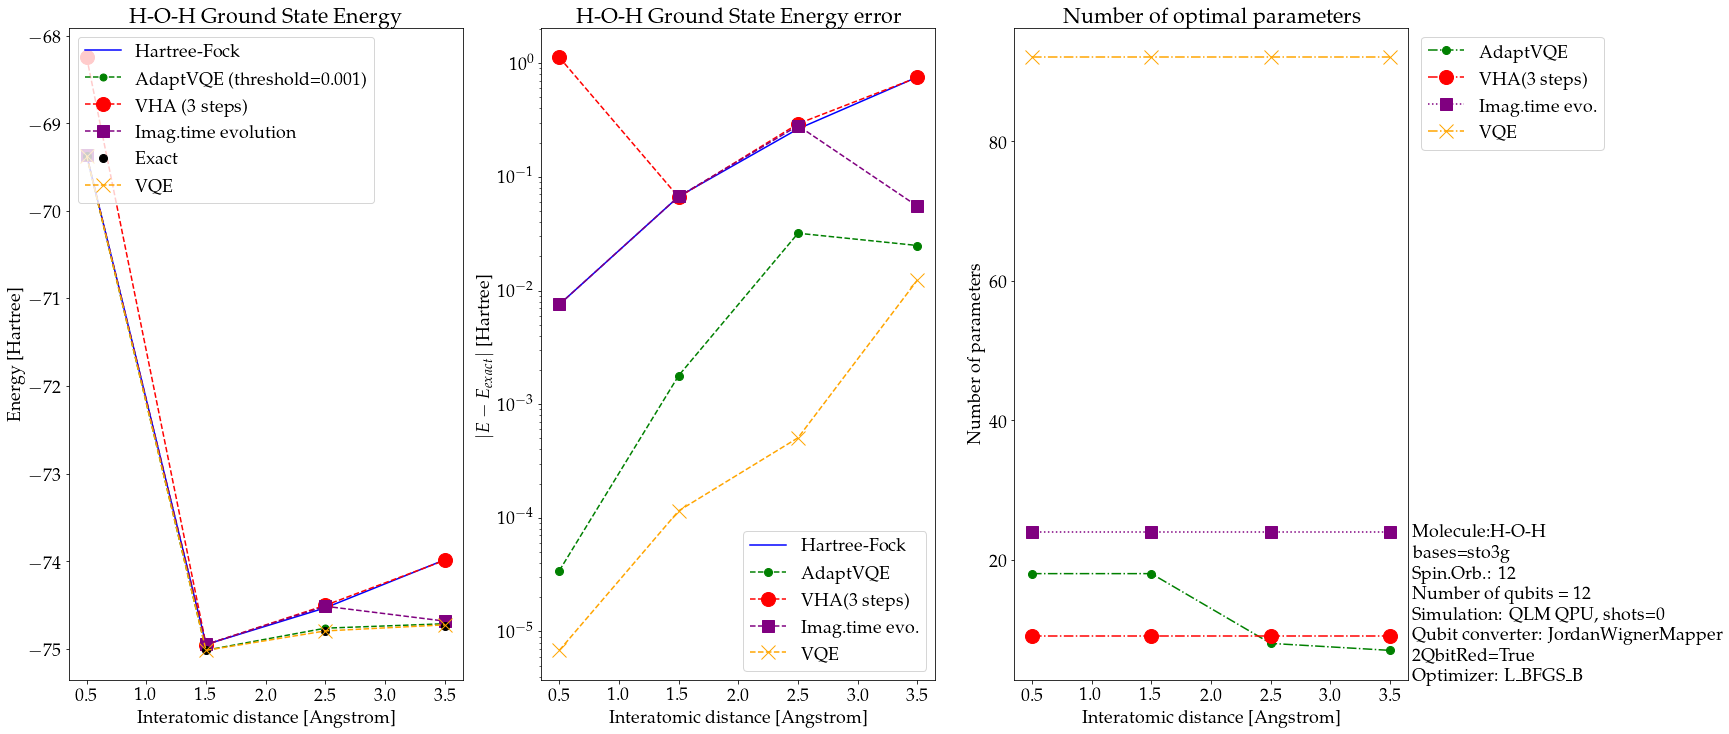

In [10]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Palatino"],
    'font.size'   : 18})

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 12))

molecule_name = "-".join([atom.strip()[0] for atom in molecule.split(';')])

hamiltonian = es_problem.second_q_ops()[0]
particle_number = es_problem.properties_transformed.get_property("ParticleNumber")
num_particles = (particle_number.num_alpha, particle_number.num_beta)
num_spin_orbitals = particle_number.num_spin_orbitals


#COLLECT USEFUL INFO TO ADD TO THE ANNOTATION IN THE PLOT
molecule_basis = 'Molecule:'+molecule_name+' \nbases='+basis
spin_orbitals = '\nSpin.Orb.: '+str(num_spin_orbitals)
label_num_qubits = '\nNumber of qubits = '+str(num_qubits)
qbconv = '\nQubit converter: '+str(qubit_converter.mapper.__class__).split('.')[-1][:-2]+' \n2QbitRed='+str(qubit_converter.two_qubit_reduction)
sv_shots = "\nSimulation: "+('QLM QPU, shots='+str(shots) if use_qlm else 'Qiskit Backend, shots='+str(shots))
optim = '\nOptimizer: '+ str(optimizer.__class__).split('.')[-1][:-2]
noiz = '\nNoise ='+str(usenoise)
# if usenoise: noiz+=', type='+str(device_backend.name())
annotation = molecule_basis+spin_orbitals+label_num_qubits+sv_shots+qbconv+optim
ann = plt.annotate(annotation, xy=(1.01, 0.0), xycoords='axes fraction')


ax1.plot(distances, hf_energies, color='blue', label='Hartree-Fock')
ax1.plot(distances, adapt_vqe_energies, '.',markersize=14,linestyle='--', color='green', label='AdaptVQE (threshold=0.001)')
ax1.plot(distances, vha_energies, 'o',markersize=14,linestyle='--', color='red', label='VHA ('+str(trotter_steps)+' steps)')
ax1.plot(distances, Ievo_energies, 's',markersize=12,linestyle='--', color='purple', label='Imag.time evolution')
ax1.plot(distances, exact_energies, '.',markersize=16, color='black', label='Exact')
ax1.plot(distances, vqe_energies, 'x',markersize=14,linestyle='--', color='orange', label='VQE')
ax1.set_xlabel('Interatomic distance [Angstrom]')
ax1.set_ylabel('Energy [Hartree]')
ax1.set_title(molecule_name+' Ground State Energy')
ax1.legend(loc='upper left')


ypoints = [abs(a - b) for a, b in zip(hf_energies, exact_energies)]
ax2.plot(distances, ypoints, color='blue', label='Hartree-Fock')
ypoints = [abs(a - b) for a, b in zip(adapt_vqe_energies, exact_energies)]
ax2.plot(distances, ypoints, '.',markersize=16, linestyle='--', color='green', label='AdaptVQE')
ypoints = [abs(a - b) for a, b in zip(vha_energies, exact_energies)]
ax2.plot(distances, ypoints, 'o',markersize=14, linestyle='--', color='red', label='VHA('+str(trotter_steps)+' steps)')
ypoints = [abs(a - b) for a, b in zip(Ievo_energies, exact_energies)]
ax2.plot(distances, ypoints, 's',markersize=12, linestyle='--', color='purple', label='Imag.time evo.')
ypoints = [abs(a - b) for a, b in zip(vqe_energies, exact_energies)]
ax2.plot(distances, ypoints, 'x',markersize=14, linestyle='--', color='orange', label='VQE')

ax2.set_yscale('log')
ax2.set_xlabel('Interatomic distance [Angstrom]')
ax2.set_ylabel('$|E-E_{exact}|$ [Hartree]')
ax2.set_title(molecule_name+' Ground State Energy error')
ax2.legend()



ax3.plot(distances, adapt_vqe_params, '.',markersize=16, linestyle='-.', color='green', label='AdaptVQE')
ax3.plot(distances, vha_params, 'o',markersize=14, linestyle='-.', color='red', label='VHA('+str(trotter_steps)+' steps)')
ax3.plot(distances, Ievo_params, 's',markersize=12, linestyle=':', color='purple', label='Imag.time evo.')
ax3.plot(distances, vqe_params, 'x',markersize=14, linestyle='-.', color='orange', label='VQE')

ax3.set_xlabel('Interatomic distance [Angstrom]')
ax3.set_ylabel('Number of parameters')
ax3.set_title('Number of optimal parameters')
ax3.legend()

lgd = plt.legend(bbox_to_anchor=(1.01, 1))
date = datetime.datetime.now().strftime("%Y-%m-%d")
if usenoise==True: 
    fig.savefig(molecule_name+'_ground_energy_noise'+date+'.png', bbox_extra_artists=(ann,lgd), bbox_inches='tight')
    fig.savefig(molecule_name+'_ground_energy_noise'+date+'.pdf', bbox_extra_artists=(ann,lgd), bbox_inches='tight')
else: 
    fig.savefig(molecule_name+'_ground_energy'+date+'.png', bbox_extra_artists=(ann,lgd), bbox_inches='tight')
    fig.savefig(molecule_name+'_ground_energy'+date+'.pdf', bbox_extra_artists=(ann,lgd), bbox_inches='tight')